* This notebook was made to look at the plume position defined by $x = \frac{\iint xf(x,y)dxdy}{\iint f(x,y)dxdy}$, $y = \frac{\iint yf(x,y)dxdy}{\iint f(x,y)dxdy}$, $f(x,y) = \int \frac{S_{0}-S}{S_{0}}dz$, affected by winds and the Coriolis force. $S_{0}$ = 30.

In [1]:
import numpy as np
import netCDF4 as nc
from salishsea_tools import (nc_tools,viz_tools,tidetools,geo_tools)
import datetime, os
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
sns.set(style="whitegrid")
sns.set_context("notebook", font_scale=1.6, rc={"lines.linewidth": 2})
%matplotlib inline
degree_signLon= u'\N{DEGREE SIGN}'+' W'
degree_signLat = u'\N{DEGREE SIGN}'+' N'

In [2]:
octriver_T = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Oct2014OnlyRiver/oct2014onlyriver_T.nc')
mayriver_T = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/May2015OnlyRiver/may2015onlyriver_T.nc')
janriver_T = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Jan2016OnlyRiver/jan2016onlyriver_T.nc')

octnowind_T = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Oct2014nowind/oct2014nowind_T.nc')
maynowind_T = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/May2015nowind/may2015nowind_T.nc')
jannowind_T = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Jan2016nowind/jan2016nowind_T.nc')

octall_T = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Oct2014combineall/oct2014all_T.nc')
mayall_T = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/May2015combineall/may2015all_T.nc')
janall_T = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Jan2016combineall/jan2016all_T.nc')

In [3]:
octriver_U = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Oct2014OnlyRiver/oct2014onlyriver_U.nc')
mayriver_U = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/May2015OnlyRiver/may2015onlyriver_U.nc')
janriver_U = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Jan2016OnlyRiver/jan2016onlyriver_U.nc')

octnowind_U = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Oct2014nowind/oct2014nowind_U.nc')
maynowind_U = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/May2015nowind/may2015nowind_U.nc')
jannowind_U = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Jan2016nowind/jan2016nowind_U.nc')

octall_U = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Oct2014combineall/oct2014all_U.nc')
mayall_U = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/May2015combineall/may2015all_U.nc')
janall_U = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Jan2016combineall/jan2016all_U.nc')

In [4]:
octriver_V = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Oct2014OnlyRiver/oct2014onlyriver_V.nc')
mayriver_V = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/May2015OnlyRiver/may2015onlyriver_V.nc')
janriver_V = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Jan2016OnlyRiver/jan2016onlyriver_V.nc')

octnowind_V = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Oct2014nowind/oct2014nowind_V.nc')
maynowind_V = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/May2015nowind/may2015nowind_V.nc')
jannowind_V = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Jan2016nowind/jan2016nowind_V.nc')

octall_V = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Oct2014combineall/oct2014all_V.nc')
mayall_V = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/May2015combineall/may2015all_V.nc')
janall_V = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Jan2016combineall/jan2016all_V.nc')

In [5]:
grid6 = nc.Dataset('/ocean/jieliu/research/meopar/river-treatment/bathy_meter_SalishSea6.nc')
X = grid6.variables['nav_lon'][:, :]
Y = grid6.variables['nav_lat'][:, :]
bathy = grid6.variables['Bathymetry'][:, :]
## tmask
mesh = nc.Dataset('/data/jieliu/MEOPAR/river-treatment/oct8_101e061e05/mesh_mask.nc')
tmask = mesh.variables['tmask'][0,:,380:510,240:397]
e3t = mesh.variables['e3t'][0,:,380:510,240:397]
e1t = mesh.variables['e1t'][0,380:510,240:397]
e2t = mesh.variables['e2t'][0,380:510,240:397]
np_mask = np.abs(1-tmask) 

In [6]:
def determine_plume_method2_onlysalinity(grid_T,tst,ted,dep_ind):
    """Similar to method1, but this time the S_ref is the spatial mean 
    of the 2.5*2.5 km in the northern of my subdomain and not plot them, only get the
    threshold salinity"""
    S = grid_T.variables['vosaline']
    lon = grid_T.variables['nav_lon']
    lat = grid_T.variables['nav_lat']
    S_aveN = np.nanmean(S[tst:ted+1,:,-5:,0:5],axis = 0) ## first temporal average of northern region
    S_ref = np.nanmean(S_aveN[dep_ind]) ## then spatial average
    S_thre = 1.14*S_ref-4.8
    S_aveW = np.nanmean(S[tst:ted+1,dep_ind],axis = 0) ## temporal averaged of the whole domain
    S_aveW = np.ma.masked_values(S_aveW, 0) ## mask 0 value
    return S_thre, S_aveW

In [7]:
def area_plume_new(grid_T,tst,ted,dep_ind,dep,S_thre,yslices,xslices):
    """S_thre is an input now"""
    jss  = []; iss = []; 
    SS,W = determine_plume_method2_onlysalinity(grid_T,tst,ted,dep)
    for j in np.arange(yslices):
        for i in np.arange(xslices):
            if W[j,i] - S_thre >= 0.:
                jss.append(j)
                iss.append(i)
    return jss, iss,W

In [8]:
def freshwater_xy(grid_T,tst,ted,dep_ind,xslices):
    """Calculate the freshwater over depths for all grid cells"""
    S0 = 30;
    S = grid_T.variables['vosaline'][tst:ted+1,:,:,:xslices]
    ssh = grid_T.variables['sossheig'][...,:xslices]
    fresh = np.zeros(S.shape)
    for t in np.arange(ted+1-tst):
        for z in np.arange(dep_ind):
            adj_ssh = 1+ssh[t+tst]/np.sum(e3t[...,:xslices]*tmask[...,:xslices],axis = 0)
            fresh[t,z] = (1-S[t,z]/S0)*e3t[z,:,:xslices]*adj_ssh[:]*tmask[z,:,:xslices] ## mask zero salinity here
    fresh_depth = np.nansum(fresh,axis = 1) ## integral over depths
    fresh_ave = np.nanmean(fresh_depth,axis=0) ## averaged over time of fresh water at each grid cell
    return fresh_ave

In [9]:
def plume_position_new(grid_T,tst,ted,dep,fresh_ave,S_thre,yslices,xslices):
    """if only use fixed plume threshold"""
    i_po_nu = np.zeros(e1t.shape); j_po_nu = np.zeros(e1t.shape); ## j position numerator
    i_po_de = np.zeros(e1t.shape); j_po_de = np.zeros(e1t.shape);
    SS,W = determine_plume_method2_onlysalinity(grid_T,tst,ted,dep)
    for jj in np.arange(yslices):
        for ii in np.arange(xslices):
            if W[jj,ii] - S_thre >= 0.:
                j_po_nu[jj,ii] = np.nan
                j_po_de[jj,ii] = np.nan
                i_po_nu[jj,ii] = np.nan
                i_po_de[jj,ii] = np.nan
            elif  W[jj,ii] - S_thre < 0:
                j_po_nu[jj,ii] = jj*fresh_ave[jj,ii]*e1t[jj,ii]*e2t[jj,ii]
                j_po_de[jj,ii] = fresh_ave[jj,ii]*e1t[jj,ii]*e2t[jj,ii]
                i_po_nu[jj,ii] = ii*fresh_ave[jj,ii]*e1t[jj,ii]*e2t[jj,ii]
                i_po_de[jj,ii] = fresh_ave[jj,ii]*e1t[jj,ii]*e2t[jj,ii]

    i_po = np.nansum(i_po_nu)/np.nansum(i_po_de)
    j_po = np.nansum(j_po_nu)/np.nansum(j_po_de)
    return j_po,i_po

In [11]:
def plot_plume_position(axs,grid_T1,grid_T2,tst,ted,dep_ind,dep,S_thre,yslices,xslices,lettersA,
                        lettersB,lettersC,strings):
    """Nine subplots, with each row of weak, moderate and strong wind, each column of with wind, without wind,
    difference, label each plot
    
    grid_T1: select which month of all_T.nc
    
    grid_T2: select which month of nowind_T.nc
    
    tst: list of start time
    
    ted: list of end time
    
    dep_ind: upper 10 m
    
    dep: 0.5 m 
    
    S_thre: already defined plume threshould for each month
    
    yslices: along-strait direction of valid boundary to calculate plume centre location 
    
    xslices: cross-strait direction of valid boundary to calculate plume centre location 
    
    lettersA: label first row
    
    lettersB: label second row
    
    lettersC: label third row
    
    strings: with or without wind forcing
    
    """
    fresh_aves = {}; ipos = {};jpos = {}
    for i in np.arange(3):
        for gridT, string, ax,c,text in zip([grid_T1,grid_T2],strings,[axs[i,0],axs[i,1]],['lawngreen','steelblue'],\
                                      [lettersA[i],lettersB[i]]):
            jss,iss,W= area_plume_new(gridT,tst[i],ted[i],dep_ind,dep,S_thre,yslices,xslices) ## plume boundary different
            fresh_aves[string] = freshwater_xy(gridT,tst[i],ted[i],dep_ind,xslices)
            jpos[string],ipos[string] = plume_position_new(gridT,tst[i],ted[i],dep,fresh_aves[string],\
                                                           S_thre,yslices,xslices)
                      
            lon = gridT.variables['nav_lon']
            lat = gridT.variables['nav_lat']

            fr_aveno0 = np.ma.masked_values(fresh_aves[string],0)
            CS = ax.pcolormesh(lon[:yslices,:xslices],lat[:yslices,:xslices],fr_aveno0[:],vmin = 0, vmax = 5,cmap = 'inferno_r')
            if ax == axs[2,0]:
                cbar_ax = fig.add_axes([0.12, 0.07, 0.25, 0.02])
                cbar = fig.colorbar(CS,cax = cbar_ax,orientation = 'horizontal')
                cbar.set_label('Freshwater thickness (m)')
            if ax == axs[2,1]:
                cbar_ax = fig.add_axes([0.39, 0.07, 0.25, 0.02])
                cbar = fig.colorbar(CS,cax = cbar_ax,orientation = 'horizontal')
                cbar.set_label('Freshwater thickness (m)')
            ax.plot(lon[jpos[string],ipos[string]],lat[jpos[string],ipos[string]],color =c,marker = '*',markersize = 14,label =string)
            ax.legend(loc = 'best')
            CS3 = ax.contour(lon[:],lat[:],W, levels = [S_thre], colors='k',linewidths=(2,)) ## add salinity boundary
            plt.clabel(CS3,fmt='%2.1f', colors='k',fontsize = 14)
            ax.plot(lon[0:,xslices],lat[0:,xslices],'r-')
            ax.text(0.02,0.92, text, transform=ax.transAxes, fontsize = 18)
        ax = axs[i,2]
        fr_aveno0 = np.ma.masked_values(fresh_aves[strings[1]]-fresh_aves[strings[0]],0)
        CS = ax.pcolormesh(lon[:yslices,:xslices],lat[:yslices,:xslices],fr_aveno0[:],vmin = -2, vmax = 2,cmap = 'bwr')
        if ax == axs[2,2]:
            cbar_ax = fig.add_axes([0.666, 0.07, 0.25, 0.02])
            cbar = fig.colorbar(CS,cax = cbar_ax,orientation = 'horizontal')
            cbar.set_label('Difference of freshwater thickness (m)')       
        ax.plot(lon[jpos[strings[0]],ipos[strings[0]]],lat[jpos[strings[0]],ipos[strings[0]]],color = 'lawngreen',marker = '*',markersize = 14,label =strings[0])
        ax.plot(lon[jpos[strings[1]],ipos[strings[1]]],lat[jpos[strings[1]],ipos[strings[1]]],color = 'steelblue',marker = '*',markersize = 14,label =strings[1]) 
        ax.legend(loc = 'best')
        ax.text(0.02,0.92, lettersC[i], transform=ax.transAxes, fontsize = 18)
    for ax in [axs[0,0],axs[0,1],axs[0,2],\
              axs[1,0],axs[1,1],axs[1,2],\
              axs[2,0],axs[2,1],axs[2,2]]:    
        viz_tools.plot_land_mask(ax,grid6,coords='map',color='burlywood')
        viz_tools.plot_coastline(ax, grid6, coords = 'map')
        ax.set_xlim([-124.,-122.6])
        ax.set_xticks([-124,-123.6,-123.2,-122.8])
        ax.set_xticklabels([str(124) +degree_signLon, str(123.6)+degree_signLon,str(123.2)+degree_signLon,str(122.8)+degree_signLon])
        ax.set_ylim([48.85,49.65])
        ax.set_yticks([48.9,49.1,49.3,49.5])
        ax.set_yticklabels([str(48.9) +degree_signLat, str(49.1)+degree_signLat,str(49.3)+degree_signLat,str(49.5)+degree_signLat])
        viz_tools.set_aspect(ax,coords='map',lats = lat)
    for ax in [axs[0,0], axs[1,0]]:
        plt.setp( ax.get_xticklabels(), visible=False)
    for ax in [axs[0,1],axs[0,2],axs[1,1],axs[1,2]]:
        plt.setp( ax.get_xticklabels(), visible=False)
        plt.setp( ax.get_yticklabels(), visible=False)
    for ax in [axs[2,1],axs[2,2]]:
        plt.setp( ax.get_yticklabels(), visible=False)
    ax = axs[2,0]
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')

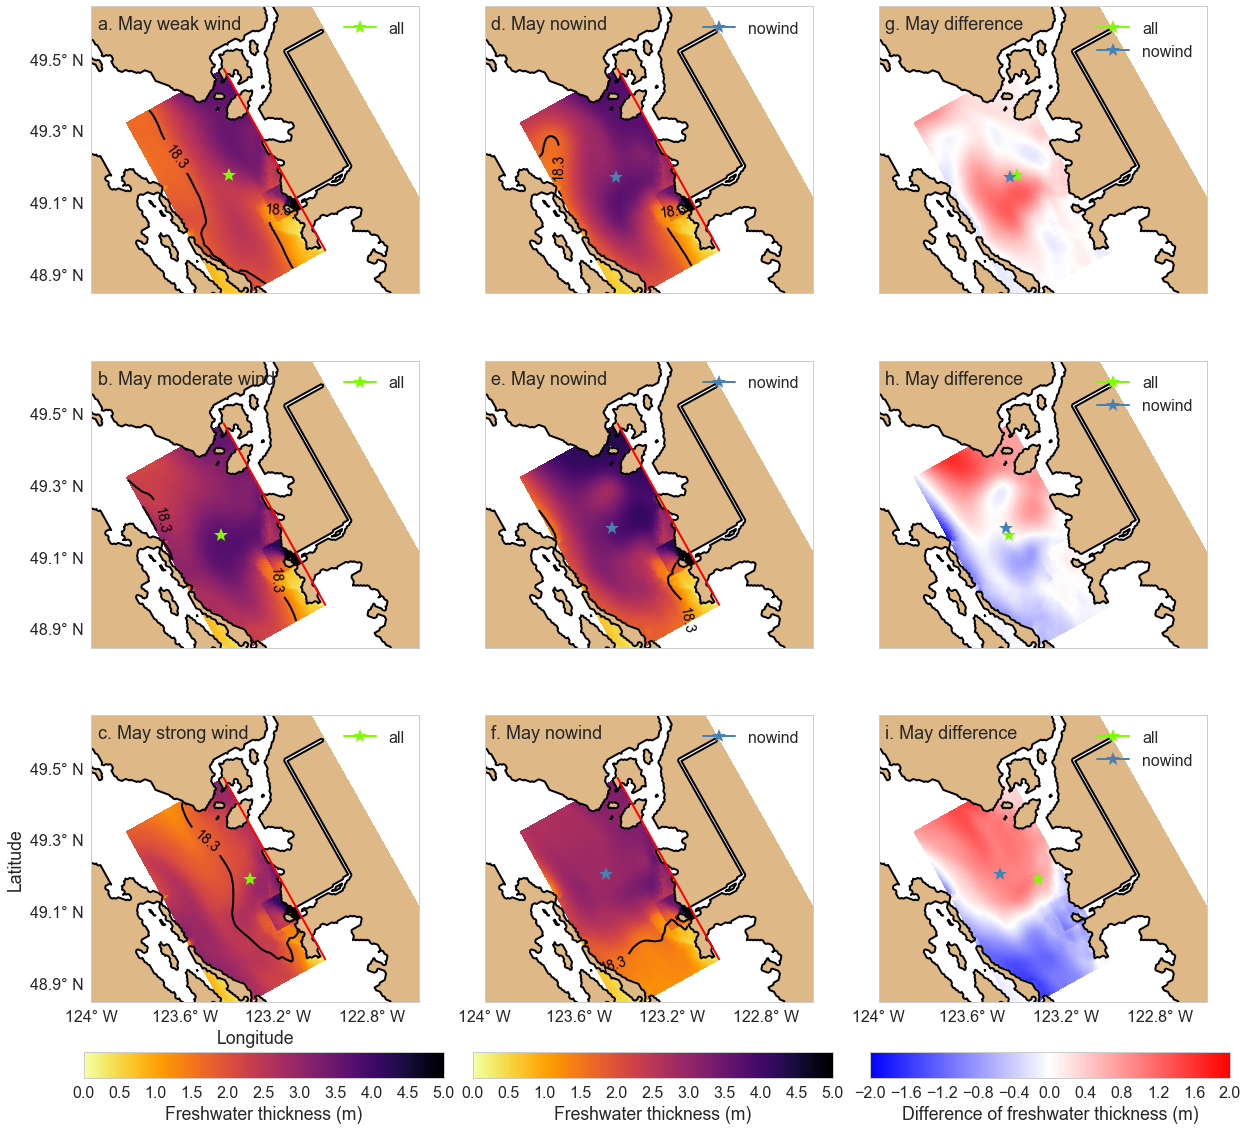

In [12]:
## Test may
fig, axs = plt.subplots(3,3,figsize = (20,18))
grid_T1 = mayall_T
grid_T2 = maynowind_T
strings = ['all','nowind']
yslices = tmask.shape[1]
xslices = tmask.shape[2]-77
tst = [192,432,24]
ted = [263,503,71]
dep_ind = 10
dep=0
S_thre = 18.3
lettersA = ['a. May weak wind', 'b. May moderate wind' ,'c. May strong wind']
lettersB = ['d. May nowind', 'e. May nowind' ,'f. May nowind']
lettersC = ['g. May difference', 'h. May difference' ,'i. May difference']
plot_plume_position(axs,grid_T1,grid_T2,tst,ted,dep_ind,dep,S_thre,yslices,xslices,lettersA,
                        lettersB,lettersC,strings)

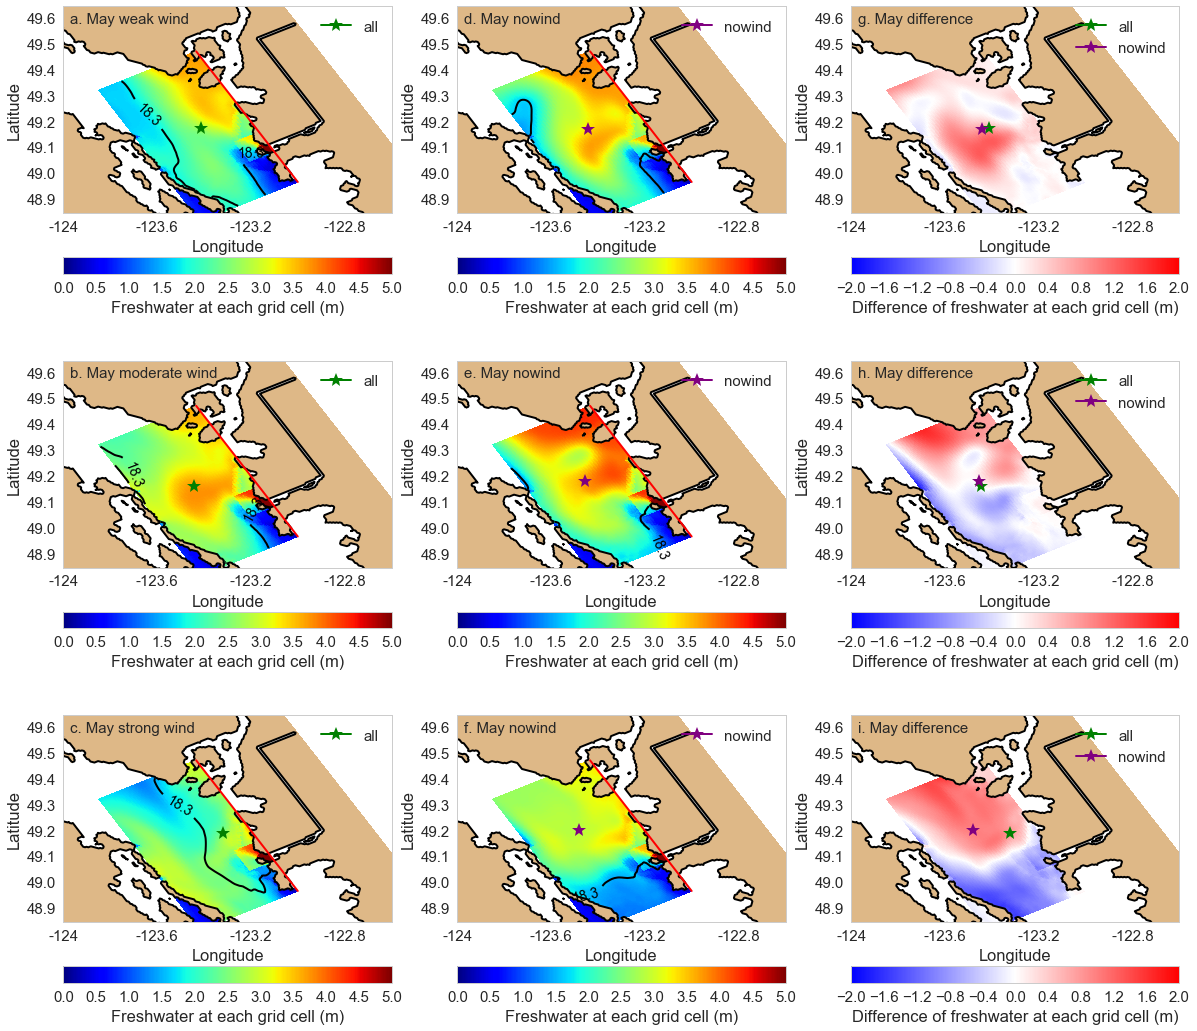

In [11]:
## May
fig, axs = plt.subplots(3,3,figsize = (20,18))
grid_T1 = mayall_T
grid_T2 = maynowind_T
strings = ['all','nowind']
yslices = tmask.shape[1]
xslices = tmask.shape[2]-77
tst = [192,432,24]
ted = [263,503,71]
dep_ind = 10
dep=0
S_thre = 18.3
lettersA = ['a. May weak wind', 'b. May moderate wind' ,'c. May strong wind']
lettersB = ['d. May nowind', 'e. May nowind' ,'f. May nowind']
lettersC = ['g. May difference', 'h. May difference' ,'i. May difference']
plot_plume_position(axs,grid_T1,grid_T2,tst,ted,dep_ind,dep,S_thre,yslices,xslices,lettersA,
                        lettersB,lettersC,strings)

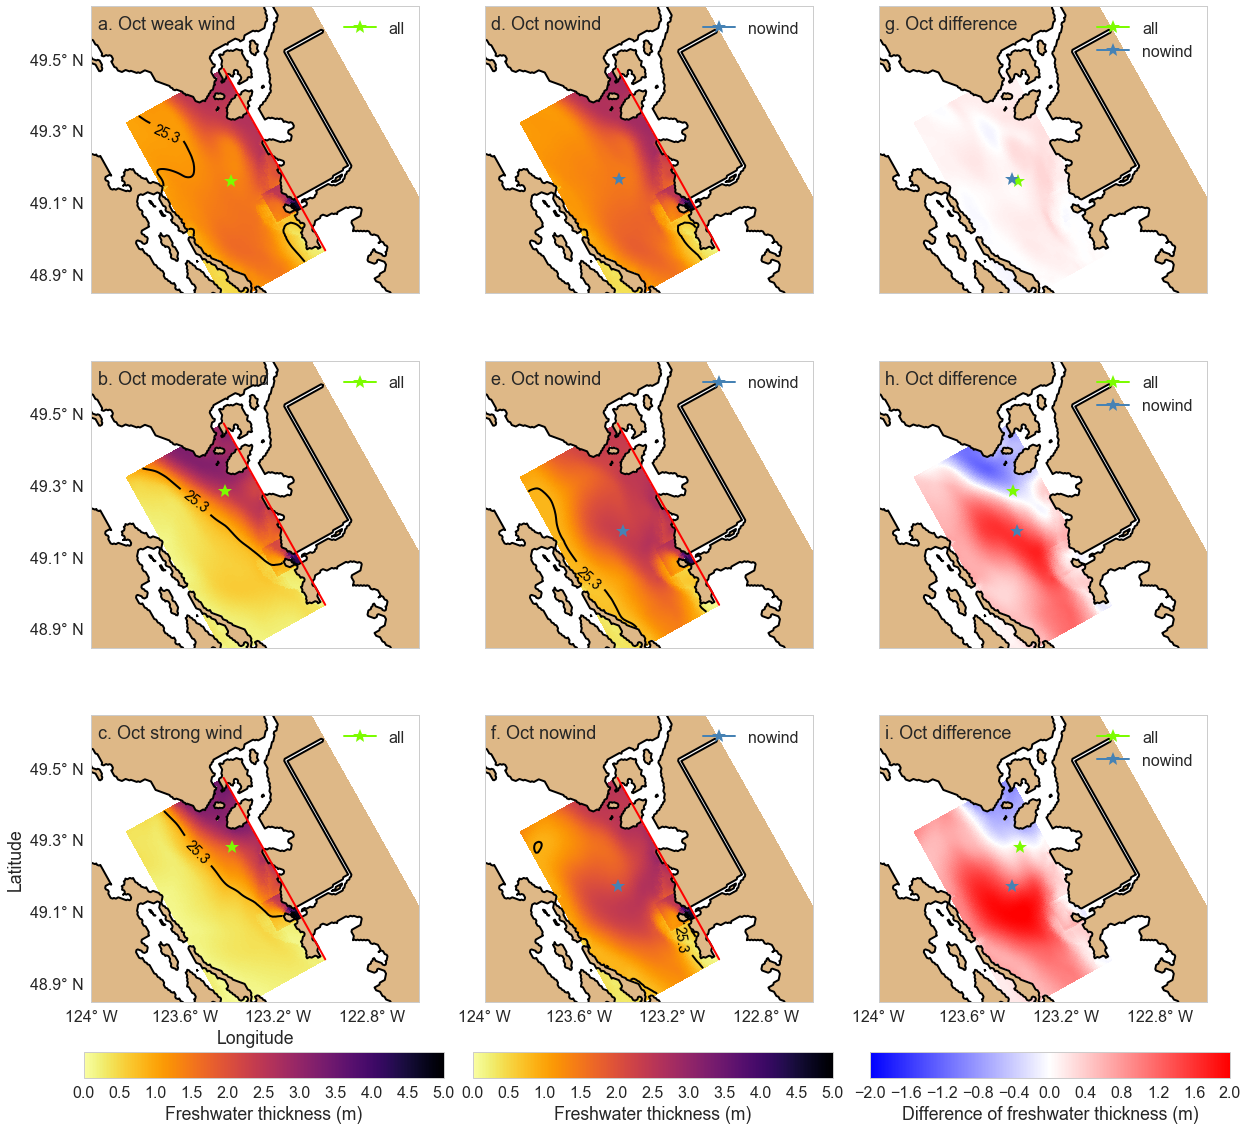

In [13]:
## Oct
fig, axs = plt.subplots(3,3,figsize = (20,18))
grid_T1 = octall_T
grid_T2 = octnowind_T
strings = ['all','nowind']
yslices = tmask.shape[1]
xslices = tmask.shape[2]-77
tst = [48,408,480]
ted = [143,480,551]
dep_ind = 10
dep=0
S_thre = 25.3
lettersA = ['a. Oct weak wind', 'b. Oct moderate wind' ,'c. Oct strong wind']
lettersB = ['d. Oct nowind', 'e. Oct nowind' ,'f. Oct nowind']
lettersC = ['g. Oct difference', 'h. Oct difference' ,'i. Oct difference']
plot_plume_position(axs,grid_T1,grid_T2,tst,ted,dep_ind,dep,S_thre,yslices,xslices,lettersA,
                        lettersB,lettersC,strings)

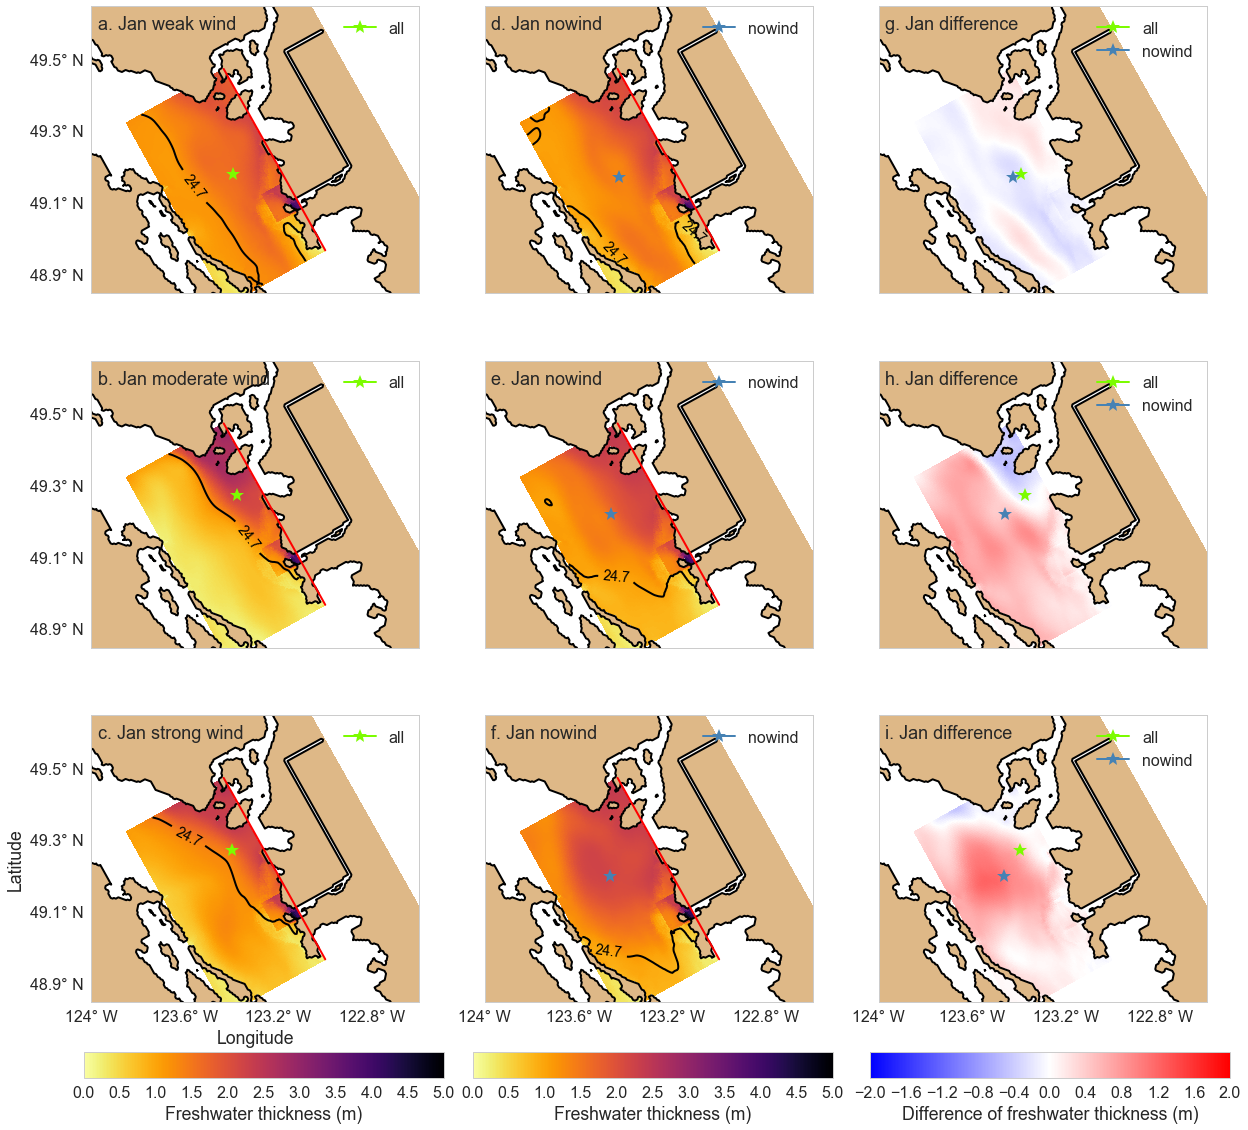

In [14]:
## Jan
fig, axs = plt.subplots(3,3,figsize = (20,18))
grid_T1 = janall_T
grid_T2 = jannowind_T
strings = ['all','nowind']
yslices = tmask.shape[1]
xslices = tmask.shape[2]-77
tst = [168,384,624]
ted = [239,455,671]
dep_ind = 10
dep=0
S_thre = 24.7
lettersA = ['a. Jan weak wind', 'b. Jan moderate wind' ,'c. Jan strong wind']
lettersB = ['d. Jan nowind', 'e. Jan nowind' ,'f. Jan nowind']
lettersC = ['g. Jan difference', 'h. Jan difference' ,'i. Jan difference']
plot_plume_position(axs,grid_T1,grid_T2,tst,ted,dep_ind,dep,S_thre,yslices,xslices,lettersA,
                        lettersB,lettersC,strings)

# River impact

In [18]:
def plot_plume_positionRiver(grid_T1,grid_T2,grid_T3,tst,ted,dep_ind,dep,yslices,xslices,strings):
    """Plot the plume position under with and without Coriolis force, or with or without moderate/strong wind,
    here by convention, grid_T1 should always be all_T.nc. Pcolormesh of last plot is the difference."""
    fresh_aves = {}; ipos = {};jpos = {}
    fig,axs = plt.subplots(1,3,figsize = (20,9))
    for gridT, string, ax,c,S_thre in zip([grid_T1,grid_T2,grid_T3],strings,[axs[0],axs[1],axs[2]],\
                                          ['g','cyan','deeppink'], [24.7,25.3,18.3]):
        jss,iss,W = area_plume_new(gridT,tst,ted,dep_ind,dep,S_thre,yslices,xslices) ## plume boundary different
        fresh_aves[string] = freshwater_xy(gridT,tst,ted,dep_ind,xslices)
        jpos[string],ipos[string] = plume_position_new(gridT,tst,ted,dep,fresh_aves[string],S_thre,yslices,xslices)
    
        lon = gridT.variables['nav_lon']
        lat = gridT.variables['nav_lat']
        
        fr_aveno0 = np.ma.masked_values(fresh_aves[string],0)
        CS = ax.pcolormesh(lon[:yslices,:xslices],lat[:yslices,:xslices],fr_aveno0[:],vmin = 0, vmax = 5,cmap = 'inferno_r')
        ax.plot(lon[jpos[string],ipos[string]],lat[jpos[string],ipos[string]],color =c,marker = '*',markersize = 14,label =string)
        ax.legend(loc = 'best')
        CS3 = ax.contour(lon[:],lat[:],W, levels = [S_thre], colors='k',linewidths=(2,)) ## add salinity boundary
        plt.clabel(CS3,fmt='%2.1f', colors='k',fontsize = 14)
        ax.plot(lon[0:,xslices],lat[0:,xslices],'r-')
    cbar_ax = fig.add_axes([0.175, 0.2, 0.7, 0.05])
    cbar = fig.colorbar(CS, cax=cbar_ax,orientation = 'horizontal')
    cbar.set_label('Freshwater thickness (m)')
    for ax in axs:    
        viz_tools.plot_land_mask(ax,grid6,coords='map',color='burlywood')
        viz_tools.plot_coastline(ax, grid6, coords = 'map')
        viz_tools.set_aspect(ax,coords = 'map',lats = lat)
        ax.set_xlim([-124.,-122.6])
        ax.set_xticks([-124,-123.6,-123.2,-122.8])
        ax.set_xticklabels([str(124) +degree_signLon, str(123.6)+degree_signLon,str(123.2)+degree_signLon,str(122.8)+degree_signLon])
        ax.set_ylim([48.85,49.65])
        ax.set_yticks([48.9,49.1,49.3,49.5])
        ax.set_yticklabels([str(48.9) +degree_signLat, str(49.1)+degree_signLat,str(49.3)+degree_signLat,str(49.5)+degree_signLat])

    for ax in [axs[1],axs[2]]:
        plt.setp( ax.get_yticklabels(), visible=False)
    ax = axs[0]
    ax.set_ylabel('Latitude')
    
    ax = axs[1]
    ax.set_xlabel('Longitude')

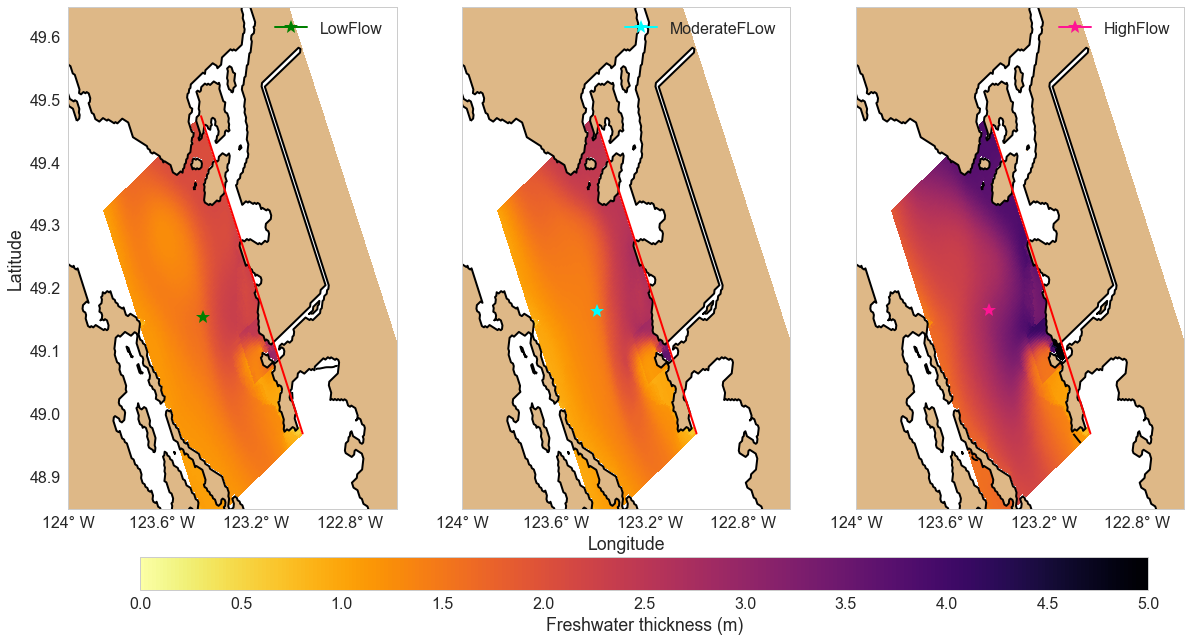

In [25]:
plot_plume_positionRiver(janriver_T,octriver_T,mayriver_T,0,743,10,0,yslices,xslices,['LowFlow','ModerateFLow','HighFlow'])

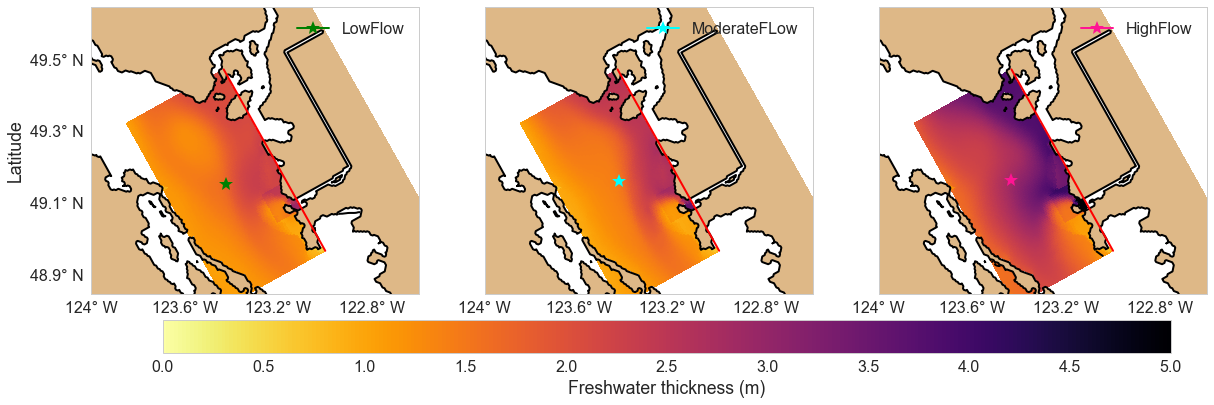

In [19]:
yslices = tmask.shape[1]
xslices = tmask.shape[2]-77
plot_plume_positionRiver(janriver_T,octriver_T,mayriver_T,0,743,10,0,yslices,xslices,['LowFlow','ModerateFLow','HighFlow'])

(48.85, 49.65)

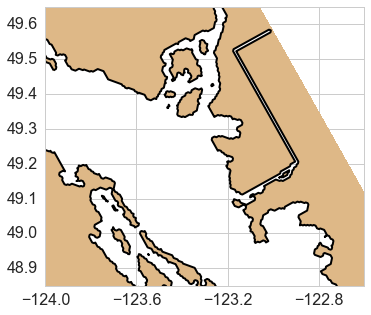

In [17]:
fig,ax = plt.subplots(1,1,figsize = (6,5))
lats = octnowind_T.variables['nav_lat']
viz_tools.plot_land_mask(ax,grid6,coords='map',color='burlywood')
viz_tools.plot_coastline(ax, grid6, coords = 'map')
viz_tools.set_aspect(ax,coords='map', lats=lats)
ax.set_xlim([-124.,-122.6])
ax.set_xticks([-124,-123.6,-123.2,-122.8])
ax.set_ylim([48.85,49.65])
